In [1]:
import pandas as pd

cancer = ["breast", "lung", "liver_ns_carcinoma", "prostate"]
cancer_antigen_peptide_list = []
for c in cancer:
    df = pd.read_csv(f"data/vaccine/{c}_mutation_peptide.tsv", header=None)
    cancer_antigen_peptide_list.append(df[0].tolist())


In [2]:
intersection_result = set(cancer_antigen_peptide_list[0]).intersection(
    cancer_antigen_peptide_list[1],
    cancer_antigen_peptide_list[2],
    cancer_antigen_peptide_list[3]
)
intersection_result = list(intersection_result)
len(intersection_result)

5092

In [3]:
df = pd.DataFrame({
    "Peptide": intersection_result,
})

In [4]:
import torch
import pickle
from fennet.mhc.mhc_binding_retriever import MHCBindingRetriever
from fennet.mhc.mhc_binding_model import ModelHlaEncoder, ModelSeqEncoder

model_version = "v0819"
pept_encoder = ModelSeqEncoder().to("cuda")
hla_encoder = ModelHlaEncoder().to("cuda")

hla_encoder.load_state_dict(torch.load(f"model/HLA_model_{model_version}.pt", map_location="cuda"))
pept_encoder.load_state_dict(torch.load(f"model/pept_model_{model_version}.pt", map_location="cuda"))

with open(f"embeds/hla_{model_version}_embeds.pkl", "rb") as f:
    data_dict = pickle.load(f)
    hla_df = data_dict["protein_df"]
    hla_embeds = data_dict["embeds"]

In [5]:
fasta_list = "uniprotkb_UP000005640_AND_reviewed_true_2024_03_01.fasta"
retriever = MHCBindingRetriever(
    hla_encoder, pept_encoder, hla_df, hla_embeds, fasta_list, digested_pept_lens=(8,15)
)

In [6]:
dists_matrix = retriever.get_binding_distances(hla_embeds, intersection_result)
dists_matrix.shape

(5092, 16454)

In [7]:
import numpy as np

def filter_alleles_by_distance_for_epitopes(distance_matrix, distance_threshold, hla_alleles):
    allele_idx_lists = [np.where(row < distance_threshold)[0] for row in distance_matrix]
    allele_id_lists = [[hla_alleles[i] for i in id_list] for id_list in allele_idx_lists]
    return allele_id_lists

In [8]:
for i in [0.1,0.2,0.3]:
    df[f"Extend Alleles <={i}"] = filter_alleles_by_distance_for_epitopes(dists_matrix, i, hla_df["allele"].tolist())

In [9]:
df = df[df['Extend Alleles <=0.1'].apply(lambda x: len(x) > 0)]

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
df

,Peptide,Extend Alleles <=0.1,Extend Alleles <=0.2,Extend Alleles <=0.3
0,LAPPQLLI,"[B59_12, B59_11, B51_187, B51_151, B51_333, B5...","[B07_210, B07_413, B07_463, B07_15, B07_57, B0...","[B07_458, B07_324, B07_462, B07_456, B08_182, ..."
1,VPNEPPEV,"[B54_18, B54_39, B59_12, B59_11, B56_89, B56_5...","[B39_63, B08_263, B07_352, B07_210, B07_310, B...","[B07_458, B07_324, B07_462, B07_456, B08_182, ..."
2,SQHMTEVL,"[B15_01, B15_142, B15_493, B15_608, B15_315, B...","[A74_07, A74_41, A32_65, A32_103, A31_08, A29_...","[A25_37, A33_171, A31_153, A03_374N, A32_149, ..."
3,TYQVSYGF,"[A24_473Q, A24_418, A24_371, A24_151, A24_95, ...","[A24_352, A24_585, A24_473Q, A24_418, A24_371,...","[A24_352, A24_585, A24_507, A24_473Q, A24_418,..."
4,EVVRRCPHQER,"[A68_01, A34_23, A34_19, A34_14, A34_31, A34_0...","[B14_12, A68_01, A34_23, A34_19, A34_14, A34_3...","[B14_12, A03_12, A68_01, A11_406, A34_23, A34_..."
...,...,...,...,...
750,YYPALNKMF,"[C01_231N, C14_104, C14_113, C14_122, C14_75, ...","[A24_181, A24_352, A24_473Q, A24_418, A24_371,...","[A24_181, C04_266, C07_02, C07_52, A24_352, A2..."
751,NYICNSSCM,"[A24_95, A24_414, A24_25, A23_05, A24_559, A24...","[A24_352, A24_585, A24_473Q, A24_418, A24_371,...","[A24_352, A24_585, A24_507, A24_473Q, A24_418,..."
752,QRTEEENLRKK,"[B27_05, B27_170, B27_175, B27_158, B27_144, B...","[B27_05, B27_196, B27_255, B27_113, B27_219, B...","[B27_05, B27_196, B27_255, B27_113, B27_146, B..."
753,RNTFQHSVV,"[C15_206, C15_252, C15_178, C15_44, C15_157, C...","[C06_244, C15_186, C02_206, C07_954N, C15_179,...","[A02_236, B07_415N, B58_112, C17_53, C17_05, C..."


In [12]:
from fennet.mhc.mhc_binding_model import embed_peptides

plot_pep_list = df["Peptide"].tolist()
pep_embeds = embed_peptides(pept_encoder, plot_pep_list)
plot_embeds = np.concatenate((pep_embeds,hla_embeds))

label_list = plot_pep_list + hla_df["allele"].tolist()


In [13]:
set1 = set([allele for sublist in df["Extend Alleles <=0.1"].tolist() for allele in sublist])
set2 = set([allele for sublist in df["Extend Alleles <=0.2"].tolist() for allele in sublist])
set3 = set([allele for sublist in df["Extend Alleles <=0.3"].tolist() for allele in sublist])

In [14]:
print(len(set3))

15472


In [ ]:
from fennet.mhc.plotting_utils import transform_embeds_to_tSNE_df

return_df = transform_embeds_to_tSNE_df(plot_embeds, label_list, 1007)

In [16]:
return_df

,t-SNE 1,t-SNE 2,label
0,-21.864016,-70.714149,LAPPQLLI
1,-34.808273,-71.004913,VPNEPPEV
2,27.130602,18.690687,SQHMTEVL
3,-65.861862,46.049652,TYQVSYGF
4,48.965645,-62.894291,EVVRRCPHQER
...,...,...,...
17204,-45.685425,16.339924,A24_26
17205,13.356209,-81.437309,A02_01
17206,-22.402079,16.175209,B44_43
17207,-15.111797,16.858519,B15_57


In [17]:
group_list = []

for i in range(return_df.shape[0]):
    tmp_label = return_df.loc[i, "label"]
    if "_" in tmp_label:
        if tmp_label in set1:
            group_list.append("binder allele <= 0.1")
        elif tmp_label in set2:
            group_list.append("binder allele <= 0.2")
        elif tmp_label in set3:
            group_list.append("binder allele <= 0.3")
        else:
            group_list.append("non-binder allele")
    else:
        group_list.append("antigen peptide")

return_df["group"] = group_list
return_df.sort_values(by="group", ascending=False, inplace=True)
return_df

,t-SNE 1,t-SNE 2,label,group
13673,4.911723,23.551332,B59_08,non-binder allele
10216,2.139119,54.673759,B39_76,non-binder allele
14602,14.546188,34.713306,B51_245N,non-binder allele
8057,13.276683,38.823471,B44_341N,non-binder allele
14603,14.546188,34.713306,B51_44N,non-binder allele
...,...,...,...,...
503,54.849411,-68.152351,QSQHMTEVMRR,antigen peptide
502,78.831802,-32.926693,KQSQPMTEVVR,antigen peptide
501,-36.936539,3.281366,ELFEMFREL,antigen peptide
500,-12.689075,49.777996,DRNTFRHIV,antigen peptide


In [18]:
group_sizes = {
    group_name: size_value
    for group_name, size_value in zip(return_df['group'].unique(), [16,16,16,16,50])
}

coord_dict = {}
for i in range(len(label_list)):
    tmp_index = return_df[return_df["label"] == label_list[i]].index[0]
    x = return_df.loc[tmp_index, "t-SNE 1"]
    y = return_df.loc[tmp_index, "t-SNE 2"]
    coord_dict[label_list[i]] = (x, y)


In [19]:
line_color = 'lightgray'

color_dict = {
    "non-binder allele": "#808080",
    "binder allele <= 0.3": "#589FF3",
    "binder allele <= 0.2": "#F3B169",
    "binder allele <= 0.1": "#F94141",
    "antigen peptide": "#37AB78"
}

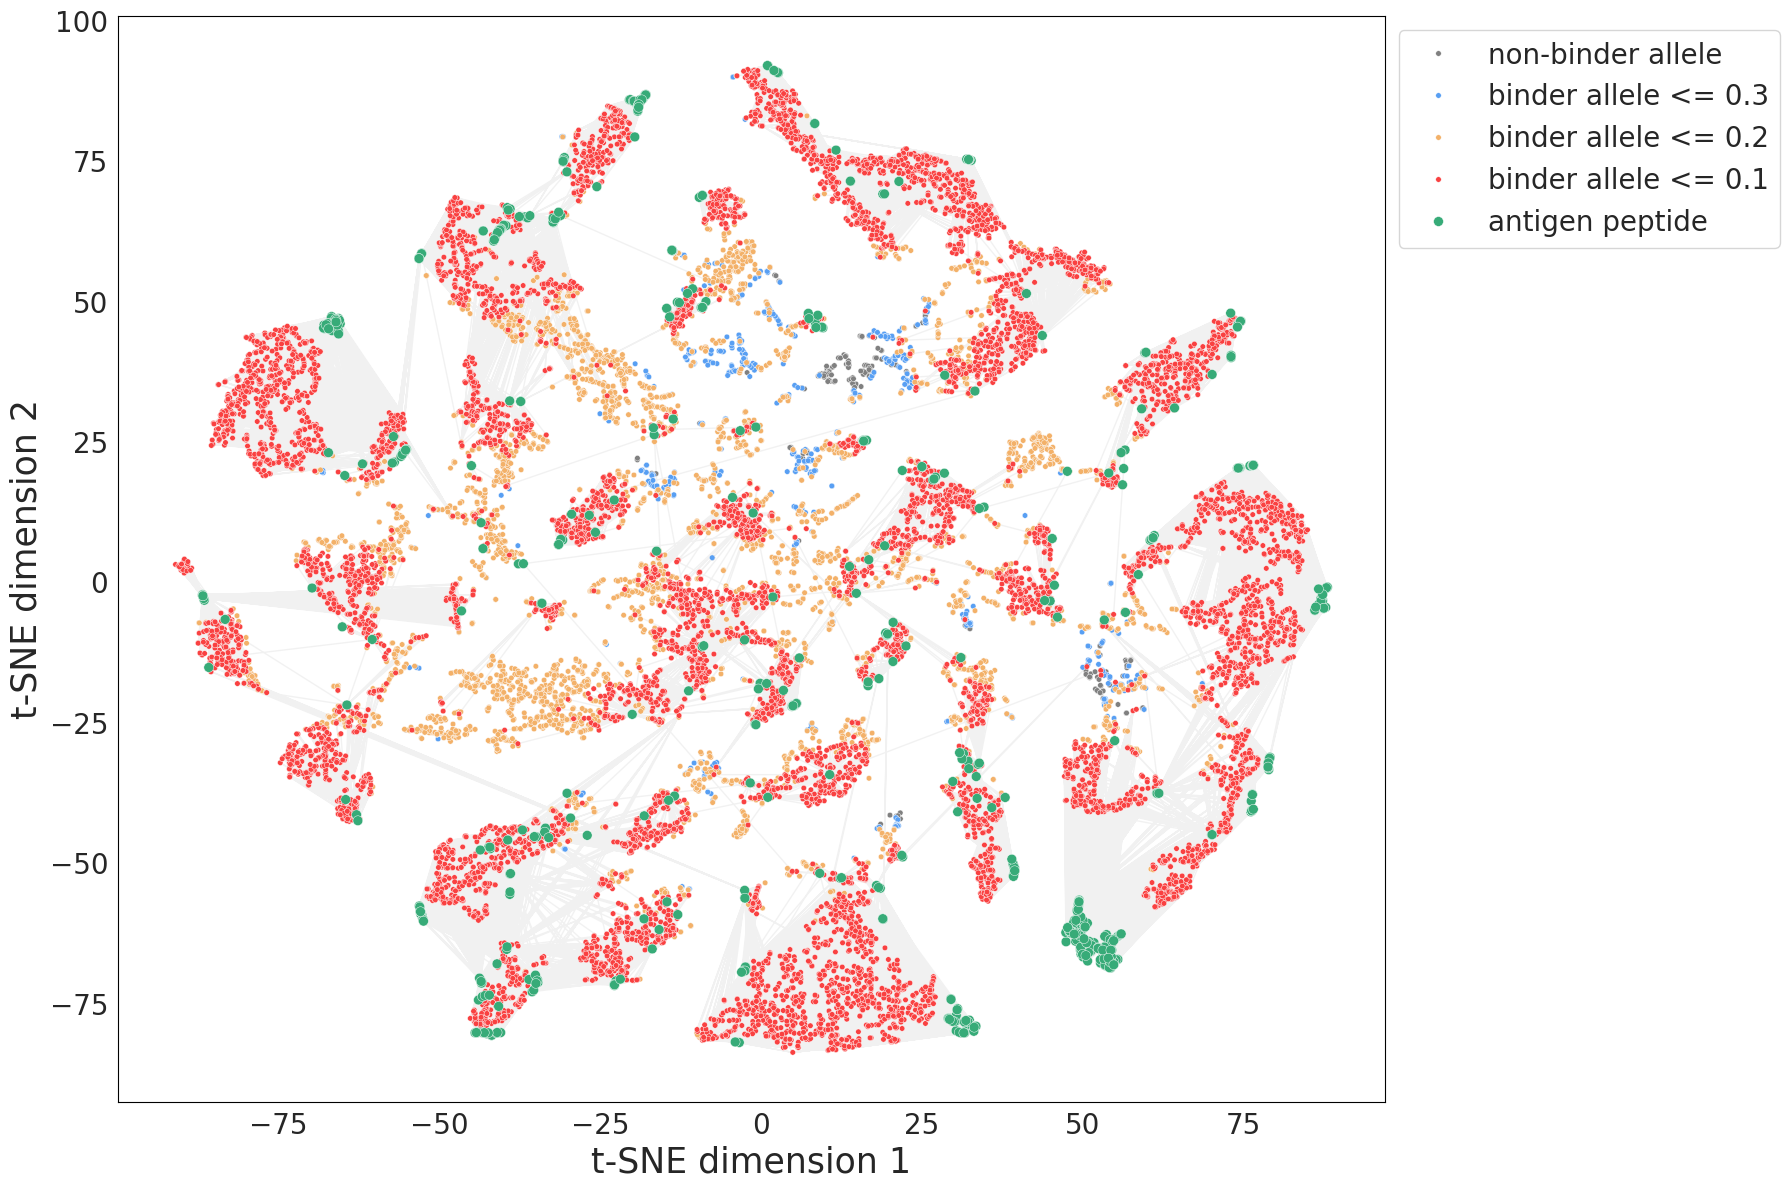

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,12))
plt.grid(False)
sns.scatterplot(data=return_df, x="t-SNE 1", y="t-SNE 2", hue="group", palette=color_dict, size="group", sizes=group_sizes)

lines_X = []
lines_Y = []

for i, row in df.iterrows():
    tmp_pep = row["Peptide"]
    pep_coord_x, pep_coord_y = coord_dict[tmp_pep]

    tmp_allele_list = df.loc[i, "Extend Alleles <=0.1"]
    for j in range(len(tmp_allele_list)):
        tmp_allele = tmp_allele_list[j]
        allele_coord_x, allele_coord_y = coord_dict[tmp_allele]
        lines_X.extend([pep_coord_x, allele_coord_x, None])
        lines_Y.extend([pep_coord_y, allele_coord_y, None])

plt.plot(lines_X, lines_Y, color=line_color, zorder=0, linewidth=1, alpha=0.3)  
plt.grid(False)
plt.xlabel("t-SNE dimension 1", fontsize=25)
plt.ylabel("t-SNE dimension 2", fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_edgecolor('black')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(20)
    
plt.tight_layout()
plt.savefig(f"figures/tSNE_cosmic_0819.svg")

In [21]:
from fennet.mhc.plotting_utils import select_optimal_a_cover

peptide_to_allele_dict = {}
for i in range(df.shape[0]):
    tmp_pep = df.loc[i, "Peptide"]
    tmp_allele_list = df.loc[i, "Extend Alleles <=0.1"]
    peptide_to_allele_dict[tmp_pep] = tmp_allele_list

In [ ]:
selected_peptides = select_optimal_a_cover(peptide_to_allele_dict, hla_df["allele"].tolist(), 0.9, 25)
selected_peptides

In [37]:
with open(f"data/vaccine/COSMIC_dist0.1_cover0.9_peptides_list.txt", "w") as f:
    for peptide in selected_peptides:
        f.write(f"{peptide}\n")

In [23]:
selected_peptides = []
with open(f"data/vaccine/COSMIC_dist0.1_cover0.9_peptides_list.txt", "r") as f:
    for line in f.readlines():
        selected_peptides.append(line.strip())
selected_peptides

['GRNSFEVCV',
 'APRVAPAPA',
 'LAPPQRLI',
 'TPVRAMAIY',
 'NRGPILTII',
 'STPPPGTRF',
 'VVRRFPHHER',
 'FEVRVFACP',
 'TYSPALNRMF',
 'TPILTIITL',
 'LFEMFREL',
 'SCMGGVNRR',
 'KTYQVSYGFRL',
 'QEDSSGNLL',
 'VMNRRPIL',
 'YSPALNKML',
 'VTCTYSPAFNK',
 'QSDPSVQPPL',
 'LPGRNSFEV',
 'RNSFEVRVY',
 'NSFEVRVY',
 'EVVRRCPHY',
 'GLAPPQDLIRV',
 'PEVGSDCTTF',
 'YSPALNKMFY']

In [24]:
new_df = df[df["Peptide"].isin(selected_peptides)]
new_df

,Peptide,Extend Alleles <=0.1,Extend Alleles <=0.2,Extend Alleles <=0.3
6,APRVAPAPA,"[B55_109, B55_98, B54_39, B56_47, B55_74, B56_...","[B39_63, B07_352, B07_210, B07_310, B07_114, B...","[B07_458, B07_324, B07_456, B08_182, B08_26, B..."
21,NRGPILTII,"[C07_205, C07_850, C07_803, C07_739, C07_735, ...","[C04_266, C07_02, C07_52, C07_962, B14_76N, B3...","[A24_181, C04_266, C07_02, C07_52, A02_1085N, ..."
23,EVVRRCPHY,"[A25_54, A26_20, A25_47, A26_154, A26_136, A26...","[A32_160N, A33_175Q, A33_19, A31_07, A01_379N,...","[A33_171, A31_153, A33_160, A29_117, A01_274, ..."
97,LPGRNSFEV,"[B07_352, B07_210, B07_310, B07_319, B07_328, ...","[B07_458, B07_324, B07_456, B08_182, B08_26, B...","[B07_458, B07_324, B07_462, B07_456, B08_182, ..."
106,NSFEVRVY,"[B15_471, B15_634, B15_01, B15_142, B15_469, B...","[A74_07, A74_41, A32_65, A32_103, A32_168N, A2...","[A25_37, A33_171, A31_153, A03_374N, A32_149, ..."
119,YSPALNKML,"[A24_278N, A24_48N, C01_214, C01_164, C01_99, ...","[A02_236, C05_52, A02_87, A02_81, A02_124, A24...","[A02_236, A24_126, C05_52, A02_1012, A30_209N,..."
128,RNSFEVRVY,"[C03_418, C16_177, C16_73, C16_144, C16_147, C...","[A03_180, B53_20, C17_53, C17_48, C17_70, C17_...","[A03_180, A24_126, B56_76, B53_20, A26_105, A2..."
146,PEVGSDCTTF,"[B44_515, B44_358, B44_322, B44_55, B18_223, B...","[B40_39, B44_478, B40_450, B44_515, B18_231Q, ...","[B37_09, B40_02, B40_39, B44_478, B40_450, B40..."
181,QEDSSGNLL,"[B40_02, B40_39, B40_431, B44_344, B40_413, B4...","[B37_09, B40_02, B40_39, B50_21, B40_431, B18_...","[B37_09, B40_02, B40_39, B44_478, B40_450, B50..."
286,TPVRAMAIY,"[B35_515, B15_508, B15_08, B15_662, B15_622, B...","[C08_224N, C12_345N, C16_206N, B35_42, B35_386...","[B56_76, B53_20, A29_169, A32_160N, A25_54, A2..."


In [25]:
set1 = set([allele for sublist in new_df["Extend Alleles <=0.1"].tolist() for allele in sublist])
set2 = set([allele for sublist in new_df["Extend Alleles <=0.2"].tolist() for allele in sublist])
set3 = set([allele for sublist in new_df["Extend Alleles <=0.3"].tolist() for allele in sublist])
total_allele_num = len(hla_df['allele'].tolist())
covered_allele_num = len(set3)
print(f"total: {total_allele_num}, covered: {covered_allele_num}, percent:{covered_allele_num/total_allele_num*100:.2f}%")

total: 16454, covered: 14617, percent:88.84%


In [26]:
plot_pep_list = new_df["Peptide"].tolist()
pep_embeds = embed_peptides(pept_encoder, plot_pep_list)
plot_embeds = np.concatenate((pep_embeds,hla_embeds))

label_list = plot_pep_list + hla_df["allele"].tolist()
len(label_list)

16479

In [27]:
return_df = transform_embeds_to_tSNE_df(plot_embeds, label_list, 1007)
return_df

,t-SNE 1,t-SNE 2,label
0,-59.586288,-13.544622,APRVAPAPA
1,-41.134235,43.952450,NRGPILTII
2,43.904854,-11.153284,EVVRRCPHY
3,-53.674149,-7.473220,LPGRNSFEV
4,25.071262,6.231339,NSFEVRVY
...,...,...,...
16474,-43.411674,26.400187,A24_26
16475,-6.384072,-82.891396,A02_01
16476,-14.249887,16.600420,B44_43
16477,-10.809011,11.212091,B15_57


In [28]:
group_list = []

for i in range(return_df.shape[0]):
    tmp_label = return_df.loc[i, "label"]
    if "_" in tmp_label:
        if tmp_label in set1:
            group_list.append("binder allele <= 0.1")
        elif tmp_label in set2:
            group_list.append("binder allele <= 0.2")
        elif tmp_label in set3:
            group_list.append("binder allele <= 0.3")
        else:
            group_list.append("non-binder allele")
    else:
        group_list.append("antigen peptide")

return_df["group"] = group_list
return_df.sort_values(by="group", ascending=False, inplace=True)
return_df

,t-SNE 1,t-SNE 2,label,group
8239,11.300214,45.722225,B15_654,non-binder allele
12872,19.800446,34.831776,B51_377N,non-binder allele
12734,55.675747,-24.242022,A33_24,non-binder allele
12757,57.126713,-14.243423,A31_126N,non-binder allele
12819,29.739632,42.615543,A31_131N,non-binder allele
...,...,...,...,...
22,-37.733288,-19.345427,LAPPQRLI,antigen peptide
23,-70.722542,35.139557,TYSPALNRMF,antigen peptide
24,83.432198,-5.713989,VTCTYSPAFNK,antigen peptide
1,-41.134235,43.952450,NRGPILTII,antigen peptide


In [29]:
group_sizes = {
    group_name: size_value
    for group_name, size_value in zip(return_df['group'].unique(), [16, 16, 16, 16, 100])
}

coord_dict = {}
for i in range(len(label_list)):
    tmp_index = return_df[return_df["label"] == label_list[i]].index[0]
    x = return_df.loc[tmp_index, "t-SNE 1"]
    y = return_df.loc[tmp_index, "t-SNE 2"]
    coord_dict[label_list[i]] = (x, y)
coord_dict

{'APRVAPAPA': (-59.58629, -13.544622),
 'NRGPILTII': (-41.134235, 43.95245),
 'EVVRRCPHY': (43.904854, -11.153284),
 'LPGRNSFEV': (-53.67415, -7.4732203),
 'NSFEVRVY': (25.071262, 6.231339),
 'YSPALNKML': (-72.44142, -35.080334),
 'RNSFEVRVY': (-1.2136139, -18.677763),
 'PEVGSDCTTF': (48.323193, 38.331085),
 'QEDSSGNLL': (35.51478, 65.12784),
 'TPVRAMAIY': (4.073747, 4.2209263),
 'YSPALNKMFY': (65.09998, 32.66336),
 'LFEMFREL': (-84.8068, -3.508921),
 'KTYQVSYGFRL': (29.2827, -65.56531),
 'VMNRRPIL': (-19.298117, 19.371828),
 'TPILTIITL': (-35.80515, 2.899489),
 'STPPPGTRF': (-39.445347, 66.961365),
 'GLAPPQDLIRV': (-6.4088573, -75.25191),
 'SCMGGVNRR': (60.640236, -55.36741),
 'GRNSFEVCV': (-18.485828, 79.79178),
 'VVRRFPHHER': (72.74296, -45.634796),
 'QSDPSVQPPL': (-44.659855, -62.868145),
 'FEVRVFACP': (7.1801815, 85.97195),
 'LAPPQRLI': (-37.733288, -19.345427),
 'TYSPALNRMF': (-70.72254, 35.139557),
 'VTCTYSPAFNK': (83.4322, -5.713989),
 'C03_159': (33.553135, -51.344246),
 'B15_

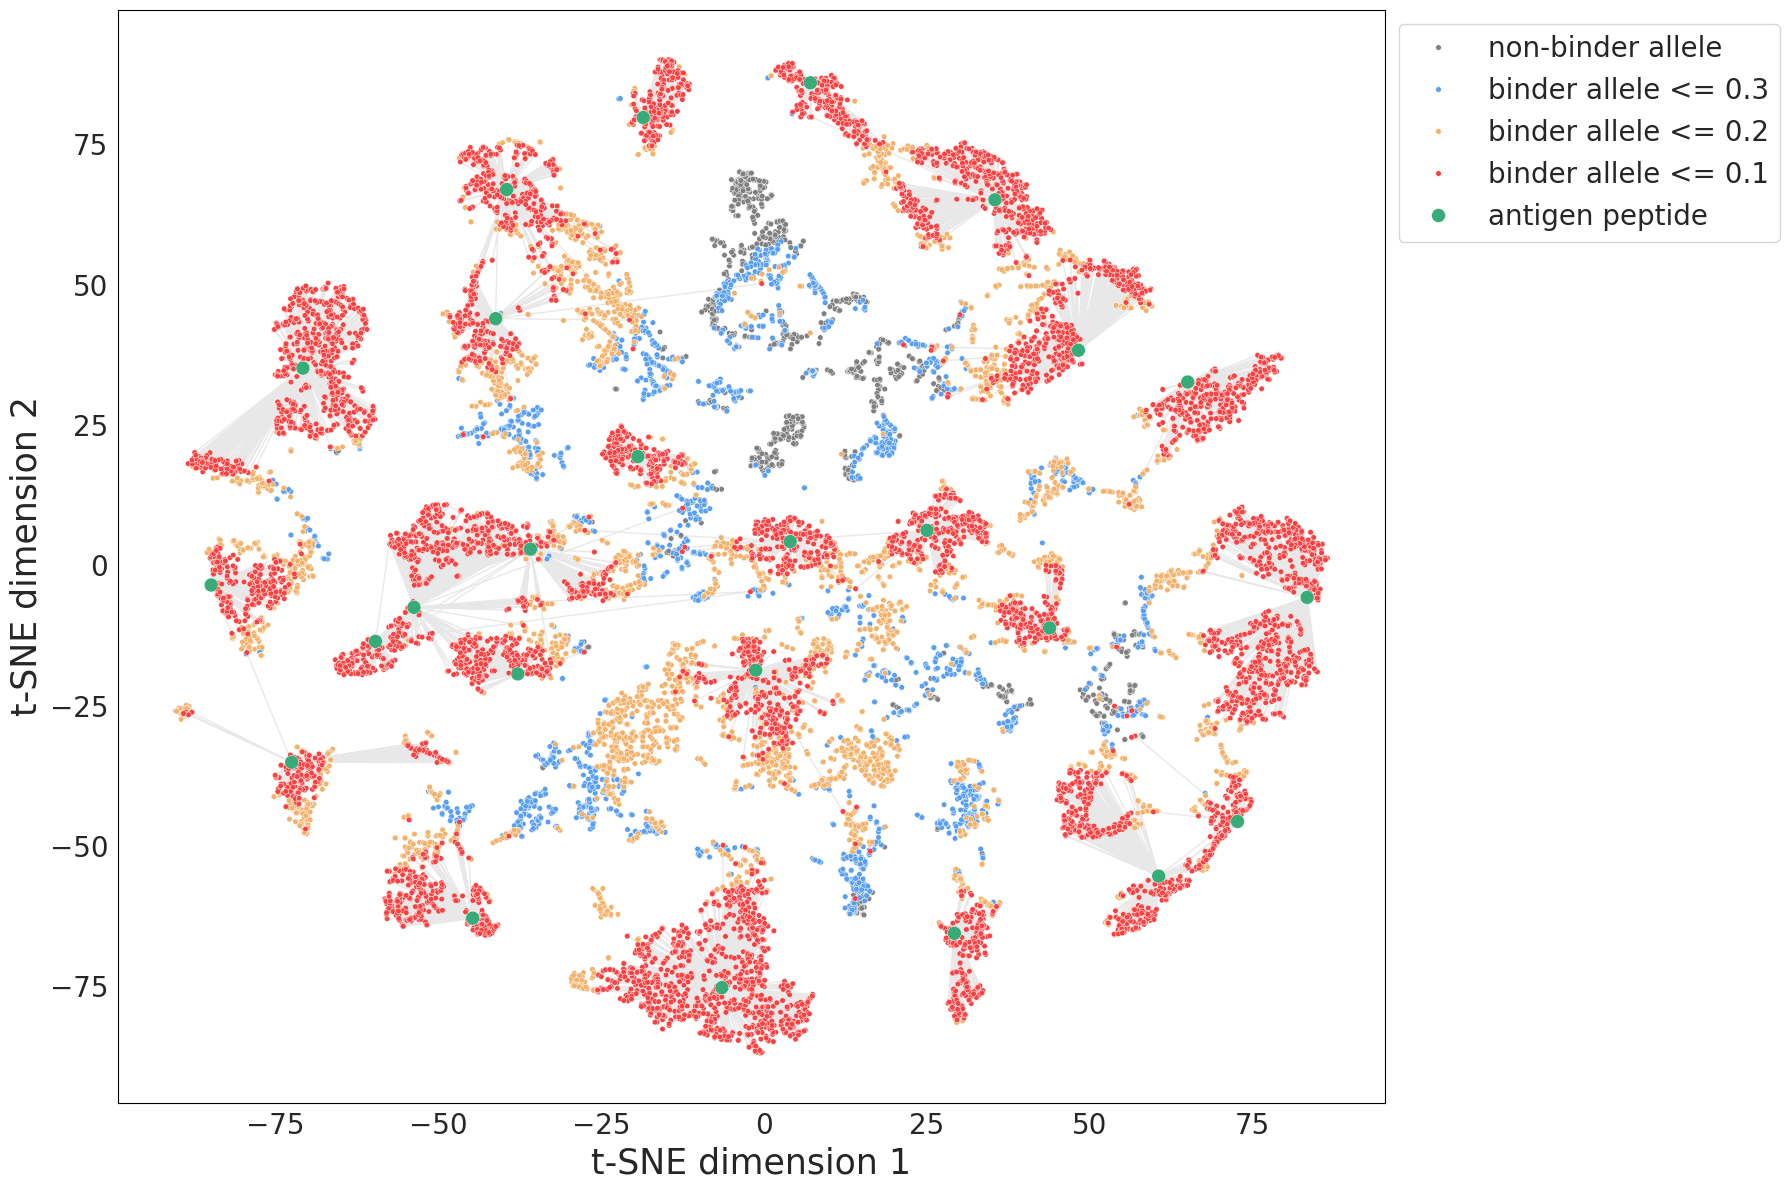

In [30]:
line_color = 'lightgray'

color_dict = {
    "non-binder allele": "#808080",
    "binder allele <= 0.3": "#589FF3",
    "binder allele <= 0.2": "#F3B169",
    "binder allele <= 0.1": "#F94141",
    "antigen peptide": "#37AB78"
}
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))
plt.grid(False)
sns.scatterplot(data=return_df, x="t-SNE 1", y="t-SNE 2", hue="group", palette=color_dict, size="group", sizes=group_sizes)

lines_X = []
lines_Y = []

for i, row in new_df.iterrows():
    tmp_pep = row["Peptide"]
    pep_coord_x, pep_coord_y = coord_dict[tmp_pep]

    tmp_allele_list = new_df.loc[i, "Extend Alleles <=0.1"]
    for j in range(len(tmp_allele_list)):
        tmp_allele = tmp_allele_list[j]
        allele_coord_x, allele_coord_y = coord_dict[tmp_allele]
        lines_X.extend([pep_coord_x, allele_coord_x, None])
        lines_Y.extend([pep_coord_y, allele_coord_y, None])

plt.plot(lines_X, lines_Y, color=line_color, zorder=0, linewidth=1, alpha=0.5)
plt.grid(False)
plt.xlabel("t-SNE dimension 1", fontsize=25)
plt.ylabel("t-SNE dimension 2", fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(20)

plt.tight_layout()
plt.savefig(f"figures/tSNE_cosmic_0819_suboptimal.svg")